In [1]:
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, format_number

spark = SparkSession.builder \
    .appName("PySparkClusterPOC") \
    .master("local") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.memory", "16g") \
    .getOrCreate()



24/11/06 01:11:25 WARN Utils: Your hostname, MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.135 instead (on interface en0)
24/11/06 01:11:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/06 01:11:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/06 01:11:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [27]:
parquet_dir = "datasets/boletins_urna_2022"
df = spark.read.parquet(parquet_dir)

# Show the schema and a few rows of the DataFrame
df.printSchema()
df.show(5)

root
 |-- DT_GERACAO: string (nullable = true)
 |-- HH_GERACAO: string (nullable = true)
 |-- ANO_ELEICAO: long (nullable = true)
 |-- CD_TIPO_ELEICAO: long (nullable = true)
 |-- NM_TIPO_ELEICAO: string (nullable = true)
 |-- CD_PLEITO: long (nullable = true)
 |-- DT_PLEITO: string (nullable = true)
 |-- NR_TURNO: long (nullable = true)
 |-- CD_ELEICAO: long (nullable = true)
 |-- DS_ELEICAO: string (nullable = true)
 |-- SG_UF: string (nullable = true)
 |-- CD_MUNICIPIO: long (nullable = true)
 |-- NM_MUNICIPIO: string (nullable = true)
 |-- NR_ZONA: long (nullable = true)
 |-- NR_SECAO: long (nullable = true)
 |-- NR_LOCAL_VOTACAO: long (nullable = true)
 |-- CD_CARGO_PERGUNTA: long (nullable = true)
 |-- DS_CARGO_PERGUNTA: string (nullable = true)
 |-- NR_PARTIDO: long (nullable = true)
 |-- SG_PARTIDO: string (nullable = true)
 |-- NM_PARTIDO: string (nullable = true)
 |-- DT_BU_RECEBIDO: string (nullable = true)
 |-- QT_APTOS: long (nullable = true)
 |-- QT_COMPARECIMENTO: long (

+----------+----------+-----------+---------------+-----------------+---------+----------+--------+----------+--------------------+-----+------------+--------------+-------+--------+----------------+-----------------+-----------------+----------+----------+--------------------+-------------------+--------+-----------------+-------------+------------+------------+---------------+---------------+----------+--------------+--------+-----------------+-------------------------+-------------------------+---------------------------+-----------------------+-----------------------+------------+-------------------+-------------------+-------------------------+-------------------+------------------+------------------+
|DT_GERACAO|HH_GERACAO|ANO_ELEICAO|CD_TIPO_ELEICAO|  NM_TIPO_ELEICAO|CD_PLEITO| DT_PLEITO|NR_TURNO|CD_ELEICAO|          DS_ELEICAO|SG_UF|CD_MUNICIPIO|  NM_MUNICIPIO|NR_ZONA|NR_SECAO|NR_LOCAL_VOTACAO|CD_CARGO_PERGUNTA|DS_CARGO_PERGUNTA|NR_PARTIDO|SG_PARTIDO|          NM_PARTIDO|     D

In [28]:
print('Total number of rows:', "{:,}".format(df.count()))

Total number of rows: 72,971,823


### Programmatic vs SQL queries

In [26]:
from pyspark.sql.functions import sum

df_filtered = df.filter(df['SG_UF'] == 'RS')

result_df = df_filtered.groupBy('NM_VOTAVEL') \
    .agg(sum('QT_VOTOS').alias('TOTAL_VOTOS'))

# Show the result
result_df.show()

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `SG_UF` cannot be resolved. Did you mean one of the following? [`NM_VOTAVEL`, `NR_VOTAVEL`, `DS_CARGO_PERGUNTA`, `TOTAL_VOTES`].

In [6]:
df.createOrReplaceTempView("boletins_urna")

result_df = spark.sql("""
    SELECT 
        NM_VOTAVEL,
        sum(QT_VOTOS) AS TOTAL_VOTOS
    FROM 
        boletins_urna
    WHERE 
        SG_UF = 'RS'
    GROUP BY 
        NM_VOTAVEL
""")

result_df.show()

+------------+----------+-------+--------+------------+
|CD_MUNICIPIO|CD_ELEICAO|NR_ZONA|NR_SECAO|SUM_QT_APTOS|
+------------+----------+-------+--------+------------+
|       88013|       544|      1|      18|        3132|
|       88013|       544|      1|      43|        1590|
|       88013|       544|      1|     194|        3120|
|       88013|       544|      1|     206|        3088|
|       88013|       544|      2|     272|        2009|
|       88013|       546|      2|     291|       74824|
|       88013|       544|      2|     366|        2436|
|       86711|       546|      3|      27|       36934|
|       87394|       546|      3|      94|       22654|
|       85073|       546|      5|       3|       49407|
|       85073|       544|      5|      57|        2728|
|       85073|       546|      5|      76|       36480|
|       85073|       544|      5|     155|        1778|
|       85553|       546|      9|      81|       47212|
|       85596|       546|     10|     160|      

### Data Exploration

In [7]:
top_10_candidates_df = spark.sql("""
    SELECT DISTINCT 
        NM_VOTAVEL,
        NR_VOTAVEL,
        SUM(QT_VOTOS) AS TOTAL_VOTES,
        DS_CARGO_PERGUNTA
    FROM
        boletins_urna
    WHERE
        DS_CARGO_PERGUNTA = 'Deputado Federal'
        AND NM_VOTAVEL != 'Branco'
        AND NM_VOTAVEL != 'Nulo'
    GROUP BY
        NR_VOTAVEL,
        NM_VOTAVEL, 
        DS_CARGO_PERGUNTA,
        CD_ELEICAO, 
        NR_TURNO
    ORDER BY
        TOTAL_VOTES DESC
    LIMIT 10
""")

top_10_candidates_df.show()

+-------------------+----------+-----------+-----------------+
|         NM_VOTAVEL|NR_VOTAVEL|TOTAL_VOTES|DS_CARGO_PERGUNTA|
+-------------------+----------+-----------+-----------------+
|   NIKOLAS FERREIRA|      2222|    1492047| Deputado Federal|
|                 PT|        13|    1263808| Deputado Federal|
|   GUILHERME BOULOS|      5010|    1001472| Deputado Federal|
|     CARLA ZAMBELLI|      2210|     946244| Deputado Federal|
|  EDUARDO BOLSONARO|      2222|     741701| Deputado Federal|
|                 PL|        22|     654473| Deputado Federal|
|     RICARDO SALLES|      2250|     640918| Deputado Federal|
|DELEGADO BRUNO LIMA|      1111|     461217| Deputado Federal|
|   DELTAN DALLAGNOL|      1919|     344917| Deputado Federal|
|      TABATA AMARAL|      4040|     337873| Deputado Federal|
+-------------------+----------+-----------+-----------------+



In [8]:
top_5_municipios_abstencoes_df = spark.sql("""
    SELECT
        NM_MUNICIPIO,
        SUM(QT_ABSTENCOES) / SUM(QT_APTOS) AS PERCENT_ABSTENCOES
    FROM
        boletins_urna
    WHERE
        SG_UF = 'RS'
    GROUP BY
        NM_MUNICIPIO
    ORDER BY
        PERCENT_ABSTENCOES DESC
    LIMIT 5
""")

# Show the result
top_5_municipios_abstencoes_df.show()

+--------------------+-------------------+
|        NM_MUNICIPIO| PERCENT_ABSTENCOES|
+--------------------+-------------------+
|SANT'ANA DO LIVRA...| 0.2917829408883093|
|              ITAQUI| 0.2847096434642711|
|          URUGUAIANA|0.27927894259569674|
|SANTA VITÓRIA DO ...| 0.2735715633223645|
|    BALNEÁRIO PINHAL| 0.2729145269208924|
+--------------------+-------------------+



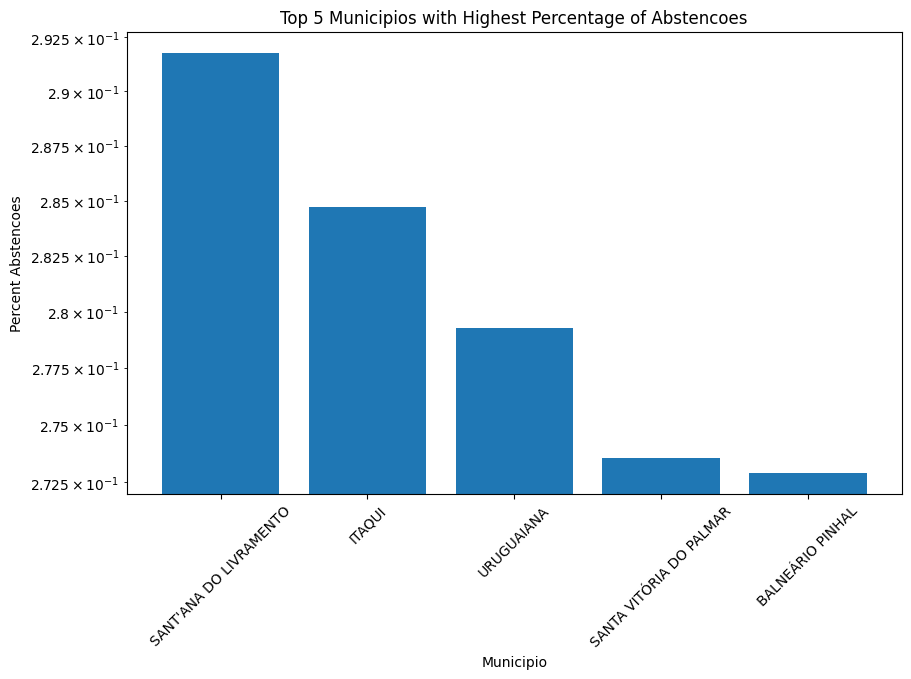

In [9]:
top_5_municipios_abstencoes_pd_df = top_5_municipios_abstencoes_df.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top_5_municipios_abstencoes_pd_df['NM_MUNICIPIO'], top_5_municipios_abstencoes_pd_df['PERCENT_ABSTENCOES'])
plt.xlabel('Municipio')
plt.ylabel('Percent Abstencoes')
plt.yscale('log')
plt.title('Top 5 Municipios with Highest Percentage of Abstencoes')
plt.xticks(rotation=45)
plt.show()

### Data Preprocessing

In [10]:
total_votes_df = spark.sql("""
    SELECT DISTINCT 
        NM_VOTAVEL,
        NR_VOTAVEL,
        DS_CARGO_PERGUNTA,
        SUM(QT_VOTOS) AS TOTAL_VOTES
    FROM
        boletins_urna
    WHERE
        NM_VOTAVEL != 'Branco' AND
        NM_VOTAVEL != 'Nulo' AND
        NR_TURNO = 1
    GROUP BY
        NR_VOTAVEL,
        NM_VOTAVEL, 
        DS_CARGO_PERGUNTA,
        CD_ELEICAO, 
        NR_TURNO
""")

output_parquet_dir = "output/total_votes"
total_votes_df.write.mode('overwrite').parquet(output_parquet_dir)

## Joining DataFrames

### Creating candidates table

In [11]:
parquet_dir = "datasets/consulta_cand_2022"
df = spark.read.option("delimiter", ";").parquet(parquet_dir)

df.printSchema()

root
 |-- DT_GERACAO: string (nullable = true)
 |-- HH_GERACAO: string (nullable = true)
 |-- ANO_ELEICAO: long (nullable = true)
 |-- CD_TIPO_ELEICAO: long (nullable = true)
 |-- NM_TIPO_ELEICAO: string (nullable = true)
 |-- NR_TURNO: long (nullable = true)
 |-- CD_ELEICAO: long (nullable = true)
 |-- DS_ELEICAO: string (nullable = true)
 |-- DT_ELEICAO: string (nullable = true)
 |-- TP_ABRANGENCIA_ELEICAO: string (nullable = true)
 |-- SG_UF: string (nullable = true)
 |-- SG_UE: string (nullable = true)
 |-- NM_UE: string (nullable = true)
 |-- CD_CARGO: long (nullable = true)
 |-- DS_CARGO: string (nullable = true)
 |-- SQ_CANDIDATO: long (nullable = true)
 |-- NR_CANDIDATO: long (nullable = true)
 |-- NM_CANDIDATO: string (nullable = true)
 |-- NM_URNA_CANDIDATO: string (nullable = true)
 |-- NM_SOCIAL_CANDIDATO: string (nullable = true)
 |-- NR_CPF_CANDIDATO: long (nullable = true)
 |-- DS_EMAIL: string (nullable = true)
 |-- CD_SITUACAO_CANDIDATURA: long (nullable = true)
 |-- D

In [12]:
df.show()

+----------+----------+-----------+---------------+-----------------+--------+----------+--------------------+----------+----------------------+-----+-----+------------------+--------+------------------+------------+------------+--------------------+--------------------+-------------------+----------------+--------------+-----------------------+-----------------------+---------------+----------+-------------+--------------------+------------+--------------------+--------------+-----------------------+------------+---------------+-----------------------+----------------+-------------+-----------------------------+---------+--------------+-----------------+--------------------+---------------+---------------+-----------+--------------+-----------+--------------------+----------------+----------------+
|DT_GERACAO|HH_GERACAO|ANO_ELEICAO|CD_TIPO_ELEICAO|  NM_TIPO_ELEICAO|NR_TURNO|CD_ELEICAO|          DS_ELEICAO|DT_ELEICAO|TP_ABRANGENCIA_ELEICAO|SG_UF|SG_UE|             NM_UE|CD_CARGO|     

In [13]:
df.createOrReplaceTempView("candidatos")

df = spark.sql("""
    SELECT DISTINCT
        NM_URNA_CANDIDATO,
        NM_CANDIDATO,
        NR_CANDIDATO,
        DS_GENERO,
        DS_COR_RACA,
        DS_GRAU_INSTRUCAO,
        DT_NASCIMENTO,
        DS_CARGO,
        DS_SIT_TOT_TURNO,
        SQ_CANDIDATO
    FROM
        candidatos
""")
        
df.show()

+--------------------+--------------------+------------+---------+-----------+--------------------+-------------+-----------------+----------------+------------+
|   NM_URNA_CANDIDATO|        NM_CANDIDATO|NR_CANDIDATO|DS_GENERO|DS_COR_RACA|   DS_GRAU_INSTRUCAO|DT_NASCIMENTO|         DS_CARGO|DS_SIT_TOT_TURNO|SQ_CANDIDATO|
+--------------------+--------------------+------------+---------+-----------+--------------------+-------------+-----------------+----------------+------------+
|         ANDRE ROCHA|ANDRE PEREIRA DA ...|       22007|MASCULINO|      PARDA|   SUPERIOR COMPLETO|   30/05/1977|DEPUTADO ESTADUAL|        SUPLENTE|140001601783|
|                ZEZO|JOSE FRANCISCO FE...|       44114|MASCULINO|     BRANCA|ENSINO MÉDIO COMP...|   02/04/1953|DEPUTADO ESTADUAL|        SUPLENTE|210001601914|
|        TIAGO FARIAS|TIAGO DA COSTA FA...|         364|MASCULINO|      PARDA|   SUPERIOR COMPLETO|   20/01/1985|      1º SUPLENTE|      NÃO ELEITO| 10001606584|
|       DELEGADO OLIM|ANTONI

### Creating votes table

In [14]:
parquet_dir = "output/total_votes"

df = spark.read.parquet(parquet_dir)

# Show the schema and a few rows of the DataFrame
df.printSchema()

root
 |-- NM_VOTAVEL: string (nullable = true)
 |-- NR_VOTAVEL: long (nullable = true)
 |-- DS_CARGO_PERGUNTA: string (nullable = true)
 |-- TOTAL_VOTES: long (nullable = true)



In [15]:
df.show()

+--------------------+----------+-----------------+-----------+
|          NM_VOTAVEL|NR_VOTAVEL|DS_CARGO_PERGUNTA|TOTAL_VOTES|
+--------------------+----------+-----------------+-----------+
|            CLOVINHO|      5189| Deputado Federal|       2097|
|   ESTELINHA DO CIEP|     12008|Deputado Estadual|        572|
|    MAURÍCIO BATISTA|     44623|Deputado Estadual|       2671|
|       RICARDO TINHA|     36061|Deputado Estadual|        567|
|        ROSE CAIÇARA|     33422|Deputado Estadual|         36|
|        CABO WELITON|     35762|Deputado Estadual|        541|
|   GILBERTO SALARINI|      1520| Deputado Federal|        884|
|     MÁRCIO ARCHANJO|     22399|Deputado Estadual|        253|
|DELEGADO ALEXANDR...|      4007| Deputado Federal|      16204|
|     BETE DA PHOENIX|     28789|Deputado Estadual|        308|
|     RIBAMAR DADINHO|     13040|Deputado Estadual|       1264|
|FREDERICO BARBOSA...|     77040|Deputado Estadual|      28592|
|      GUILHERME MEME|     10505|Deputad

In [16]:
df.createOrReplaceTempView("votos")

In [17]:
test_df = spark.sql("""
    SELECT
        *
    FROM votos
""")
test_df.sort(col("TOTAL_VOTES").desc()).show()

+--------------------+----------+-----------------+-----------+
|          NM_VOTAVEL|NR_VOTAVEL|DS_CARGO_PERGUNTA|TOTAL_VOTES|
+--------------------+----------+-----------------+-----------+
|                LULA|        13|       Presidente|   57259504|
|      JAIR BOLSONARO|        22|       Presidente|   51072345|
|ASTRONAUTA MARCOS...|       222|          Senador|   10714913|
|            TARCÍSIO|        10|       Governador|    9881995|
|     FERNANDO HADDAD|        13|       Governador|    8337139|
|       MÁRCIO FRANÇA|       400|          Senador|    7822518|
|                ZEMA|        30|       Governador|    6094136|
|      CLÁUDIO CASTRO|        22|       Governador|    4930288|
|        SIMONE TEBET|        15|       Presidente|    4915423|
|      RODRIGO GARCIA|        45|       Governador|    4296293|
|           CLEITINHO|       200|          Senador|    4268193|
|CARLOS MASSA RATI...|        55|       Governador|    4243292|
|        OTTO ALENCAR|       555|       

### Creating the expenses table

In [18]:
parquet_dir = "datasets/prestacao_contas_2022"
despesas_contratadas_df = spark.read.option("pathGlobFilter", "despesas_contratadas_candidatos_*").option("delimiter", ";").parquet(parquet_dir)

despesas_contratadas_df = despesas_contratadas_df.withColumn("VR_DESPESA_CONTRATADA", regexp_replace(col("VR_DESPESA_CONTRATADA"), ",", ".").cast("float"))

despesas_contratadas_df.createOrReplaceTempView("despesas_contratadas")
despesas_contratadas_df.printSchema()

root
 |-- DT_GERACAO: string (nullable = true)
 |-- HH_GERACAO: string (nullable = true)
 |-- ANO_ELEICAO: long (nullable = true)
 |-- CD_TIPO_ELEICAO: long (nullable = true)
 |-- NM_TIPO_ELEICAO: string (nullable = true)
 |-- CD_ELEICAO: long (nullable = true)
 |-- DS_ELEICAO: string (nullable = true)
 |-- DT_ELEICAO: string (nullable = true)
 |-- ST_TURNO: long (nullable = true)
 |-- TP_PRESTACAO_CONTAS: string (nullable = true)
 |-- DT_PRESTACAO_CONTAS: string (nullable = true)
 |-- SQ_PRESTADOR_CONTAS: long (nullable = true)
 |-- SG_UF: string (nullable = true)
 |-- SG_UE: string (nullable = true)
 |-- NM_UE: string (nullable = true)
 |-- NR_CNPJ_PRESTADOR_CONTA: long (nullable = true)
 |-- CD_CARGO: long (nullable = true)
 |-- DS_CARGO: string (nullable = true)
 |-- SQ_CANDIDATO: long (nullable = true)
 |-- NR_CANDIDATO: long (nullable = true)
 |-- NM_CANDIDATO: string (nullable = true)
 |-- NR_CPF_CANDIDATO: long (nullable = true)
 |-- NR_CPF_VICE_CANDIDATO: long (nullable = true

In [19]:
despesas_contratadas_df.show()

+----------+----------+-----------+---------------+---------------+----------+--------------------+----------+--------+-------------------+-------------------+-------------------+-----+-----+-----+-----------------------+--------+-----------------+------------+------------+--------------------+----------------+---------------------+----------+----------+--------------------+------------------+------------------+------------------+------------------+----------------------+--------------------+--------------------+-------------------------+-------------------------+----------------+-----------------------+-----------------------+-----------------------+-----------------------+-------------------+-------------------+---------------------+---------------------+---------------------+-----------------+------------+-----------------+--------------------+----------+----------+--------------------+---------------------+
|DT_GERACAO|HH_GERACAO|ANO_ELEICAO|CD_TIPO_ELEICAO|NM_TIPO_ELEICAO|CD_ELEIC

In [20]:
parquet_dir = "datasets/prestacao_contas_2022"
despesas_pagas_df = spark.read.option("pathGlobFilter", "despesas_pagas_candidatos_*").option("delimiter", ";").parquet(parquet_dir)

despesas_pagas_df = despesas_pagas_df.withColumn("VR_PAGTO_DESPESA", regexp_replace(col("VR_PAGTO_DESPESA"), ",", ".").cast("float"))

despesas_pagas_df.createOrReplaceTempView("despesas_pagas")

In [21]:
despesas_pagas_df.show()

+----------+----------+-----------+---------------+---------------+----------+--------------------+----------+--------+-------------------+-------------------+-------------------+-----+-----------------+---------------+----------------+--------------------+-----------------+--------------------+-------------------+-------------------+------------------+--------------------+----------+-----------------------+----------------+--------------------+----------------+
|DT_GERACAO|HH_GERACAO|ANO_ELEICAO|CD_TIPO_ELEICAO|NM_TIPO_ELEICAO|CD_ELEICAO|          DS_ELEICAO|DT_ELEICAO|ST_TURNO|TP_PRESTACAO_CONTAS|DT_PRESTACAO_CONTAS|SQ_PRESTADOR_CONTAS|SG_UF|DS_TIPO_DOCUMENTO|   NR_DOCUMENTO|CD_FONTE_DESPESA|    DS_FONTE_DESPESA|CD_ORIGEM_DESPESA|   DS_ORIGEM_DESPESA|CD_NATUREZA_DESPESA|DS_NATUREZA_DESPESA|CD_ESPECIE_RECURSO|  DS_ESPECIE_RECURSO|SQ_DESPESA|SQ_PARCELAMENTO_DESPESA|DT_PAGTO_DESPESA|          DS_DESPESA|VR_PAGTO_DESPESA|
+----------+----------+-----------+---------------+---------------

In [22]:
from pyspark.sql.functions import desc

despesas_df = spark.sql("""
WITH despesas AS
   ( SELECT 
            SQ_CANDIDATO,
            VR_DESPESA_CONTRATADA AS VR_DESPESA
        FROM 
            despesas_contratadas
        WHERE 
            ST_TURNO = 1
        
        UNION ALL
        
        SELECT 
            SQ_PRESTADOR_CONTAS AS SQ_CANDIDATO,
            VR_PAGTO_DESPESA AS VR_DESPESA
        FROM 
            despesas_pagas
        WHERE 
            ST_TURNO = 1) 
            
                
            SELECT SQ_CANDIDATO, SUM(VR_DESPESA) AS total_despesas FROM despesas GROUP BY SQ_CANDIDATO


""")

despesas_df.createOrReplaceTempView("despesas")

despesas_df.sort(desc("total_despesas")).show()

+------------+--------------------+
|SQ_CANDIDATO|      total_despesas|
+------------+--------------------+
|280001644128| 7.877176538847494E7|
|280001607833| 7.678105487223148E7|
|  3774520211| 7.675991926850909E7|
|280001612393|  7.20272815177126E7|
|  3781393930| 7.202728145255184E7|
|  3795118113| 6.724999443437338E7|
|250001612450| 5.913213899734497E7|
|  3781018740| 5.913213893191528E7|
|190001615753| 3.864503368748617E7|
|130001701690| 3.537215859633756E7|
|  3804143955| 3.443215859110165E7|
|130001621812|3.2163734034204483E7|
|  3790205754|3.2163734025675774E7|
|  3785028275| 2.959999992186117E7|
|160001614467|2.8085199472186107E7|
|190001614665|2.7313774860948086E7|
|100001599612|2.5053083560040474E7|
|  3783875552| 2.500242400377035E7|
|  3786144167| 2.451867096593094E7|
|170001618087|2.4518670963021755E7|
+------------+--------------------+
only showing top 20 rows



### Joining the tables

In [23]:
# SQL query to join votos and candidatos tables and display the required information
join_df = spark.sql("""
    SELECT DISTINCT 
        v.NM_VOTAVEL,
        v.NR_VOTAVEL,
        c.DS_GENERO,
        c.DS_COR_RACA,
        c.DS_GRAU_INSTRUCAO,
        c.DT_NASCIMENTO,
        v.TOTAL_VOTES,
        d.total_despesas
    FROM 
        votos v
    INNER JOIN 
        candidatos c
    ON 
        v.NR_VOTAVEL = c.NR_CANDIDATO
        AND lower(v.DS_CARGO_PERGUNTA) = lower(c.DS_CARGO)
        AND v.NM_VOTAVEL = c.NM_URNA_CANDIDATO
    LEFT JOIN 
        despesas d
    ON
        c.SQ_CANDIDATO = d.SQ_CANDIDATO
""")


join_df = join_df.withColumn("total_despesas", format_number(col("total_despesas"), 2))


# Show the result
join_df.sort(col("TOTAL_VOTES").desc()).show()

+--------------------+----------+---------+-----------+--------------------+-------------+-----------+--------------+
|          NM_VOTAVEL|NR_VOTAVEL|DS_GENERO|DS_COR_RACA|   DS_GRAU_INSTRUCAO|DT_NASCIMENTO|TOTAL_VOTES|total_despesas|
+--------------------+----------+---------+-----------+--------------------+-------------+-----------+--------------+
|                LULA|        13|MASCULINO|     BRANCA|ENSINO FUNDAMENTA...|   06/10/1945|   57259504|          NULL|
|      JAIR BOLSONARO|        22|MASCULINO|     BRANCA|   SUPERIOR COMPLETO|   21/03/1955|   51072345|          NULL|
|ASTRONAUTA MARCOS...|       222|MASCULINO|     BRANCA|   SUPERIOR COMPLETO|   11/03/1963|   10714913|  9,100,098.63|
|            TARCÍSIO|        10|MASCULINO|     BRANCA|   SUPERIOR COMPLETO|   19/06/1975|    9881995|          NULL|
|     FERNANDO HADDAD|        13|MASCULINO|     BRANCA|   SUPERIOR COMPLETO|   25/01/1963|    8337139|          NULL|
|       MÁRCIO FRANÇA|       400|MASCULINO|     BRANCA| 

In [24]:
from pyspark.sql.functions import to_date, current_date, datediff, col

join_df = join_df.withColumn("DT_NASCIMENTO", to_date(col("DT_NASCIMENTO"), "dd/MM/yyyy"))

join_df = join_df.withColumn("nr_idade", (datediff(current_date(), col("DT_NASCIMENTO")) / 365).cast("int"))

join_df.sort(col("TOTAL_VOTES").desc()).show()

+--------------------+----------+---------+-----------+--------------------+-------------+-----------+--------------+--------+
|          NM_VOTAVEL|NR_VOTAVEL|DS_GENERO|DS_COR_RACA|   DS_GRAU_INSTRUCAO|DT_NASCIMENTO|TOTAL_VOTES|total_despesas|nr_idade|
+--------------------+----------+---------+-----------+--------------------+-------------+-----------+--------------+--------+
|                LULA|        13|MASCULINO|     BRANCA|ENSINO FUNDAMENTA...|   1945-10-06|   57259504|          NULL|      79|
|      JAIR BOLSONARO|        22|MASCULINO|     BRANCA|   SUPERIOR COMPLETO|   1955-03-21|   51072345|          NULL|      69|
|ASTRONAUTA MARCOS...|       222|MASCULINO|     BRANCA|   SUPERIOR COMPLETO|   1963-03-11|   10714913|  9,100,098.63|      61|
|            TARCÍSIO|        10|MASCULINO|     BRANCA|   SUPERIOR COMPLETO|   1975-06-19|    9881995|          NULL|      49|
|     FERNANDO HADDAD|        13|MASCULINO|     BRANCA|   SUPERIOR COMPLETO|   1963-01-25|    8337139|         

In [25]:
output_parquet_dir = "output/join_table"

join_df.write.mode('overwrite').parquet(output_parquet_dir)